In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import json
import healpy as hp
import numpy as np
import cartopy.crs as ccrs
import torch
from earth2grid import healpix
from cbottle import visualizations

In [2]:
nc_path = "/home/stip-sac/pharfouc/Downscaling/cbottle/cBottle/data/outputs/tmp/0.nc"
ds = xr.open_dataset(nc_path)
display(ds)

<xarray.Dataset> Size: 604MB
Dimensions:   (crs: 1, time: 1, pix: 12582912)
Coordinates:
  * crs       (crs) float32 4B 9.969e+36
  * time      (time) datetime64[ns] 8B 2015-01-01
Dimensions without coordinates: pix
Data variables:
    cllvi     (time, pix) float32 50MB ...
    clivi     (time, pix) float32 50MB ...
    tas       (time, pix) float32 50MB ...
    uas       (time, pix) float32 50MB ...
    vas       (time, pix) float32 50MB ...
    rlut      (time, pix) float32 50MB ...
    rsut      (time, pix) float32 50MB ...
    pres_msl  (time, pix) float32 50MB ...
    pr        (time, pix) float32 50MB ...
    rsds      (time, pix) float32 50MB ...
    sst       (time, pix) float32 50MB ...
    sic       (time, pix) float32 50MB ...
Attributes:
    history:  scripts/inference_multidiffusion.py checkpoints/cBottle-SR.zip ...

In [3]:
var = "uas"
uas = ds[var][0].values
# uas = healpix.reorder(uas, healpix.PixelOrder.NEST, healpix.PixelOrder.RING)
uas_tensor = torch.tensor(uas).float().unsqueeze(0).unsqueeze(0)  # shape [1, 1, n_pix]

In [4]:
def prepare(x):
    # x: [1, 1, n_pix]
    return {
        var: x[:, 0, None].cpu()  # [1, n_pix, 1]
    }

In [6]:
input_data = prepare(uas_tensor)

# Charger les cibles depuis le fichier ERA5
target_nc_path = "/home/stip-sac/pharfouc/Downscaling/cbottle/cBottle/data/inputs/ERA5/processed/11122018-15:00/era5_hpx64_2018.nc"
ds_target = xr.open_dataset(target_nc_path)

# Extraire la même variable et la même timestamp (à ajuster si besoin)
target_uas = ds_target[var][0].values
target_tensor = torch.tensor(target_uas).float().unsqueeze(0).unsqueeze(0)

target_data = prepare(target_tensor)
output_data = input_data

In [7]:
def diagnostics(pred, lr, target):
    titles = ["input", "prediction", "target"]
    for var in pred.keys():
        plt.figure(figsize=(30, 10))
        vmin = torch.min(pred[var][0, 0])
        vmax = torch.max(pred[var][0, 0])
        for idx, data, title in zip(
            np.arange(1, 4), [lr[var][0, 0], pred[var][0, 0], target[var][0, 0]], titles
        ):
            visualizations.visualize(
                data,
                pos=(1, 3, idx),
                title=title,
                nlat=1024,
                nlon=2048,
                vmin=vmin,
                vmax=vmax,
            )
        plt.tight_layout()
        plt.show()

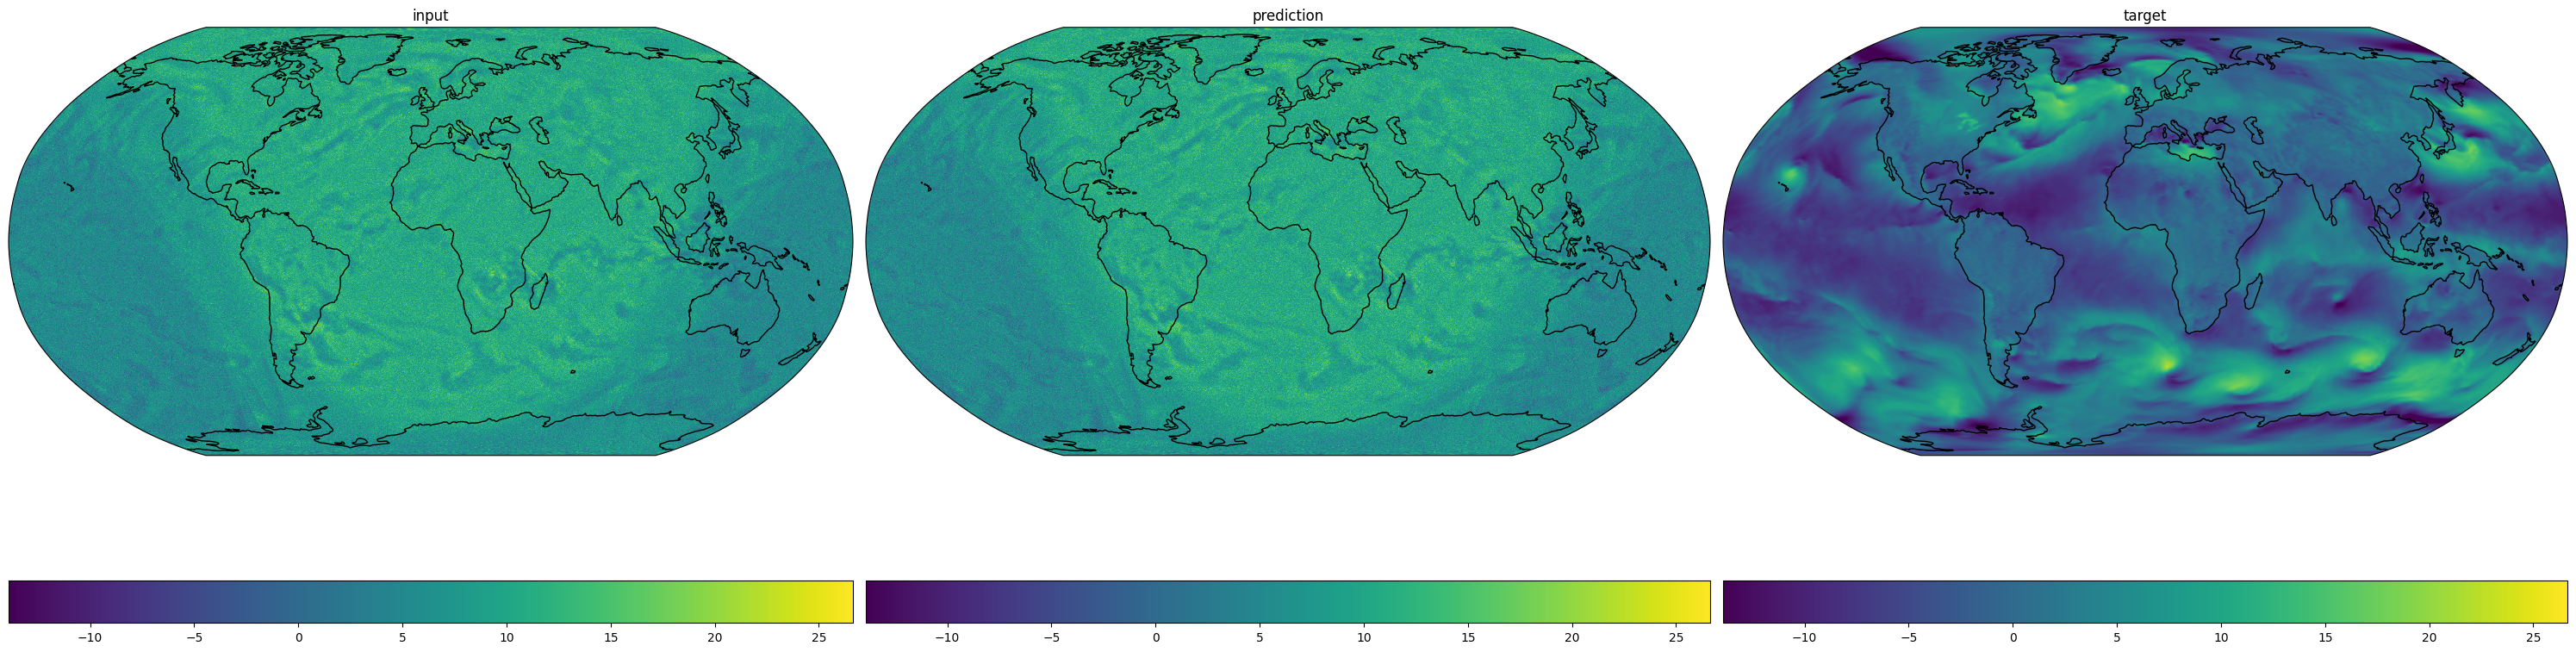

In [8]:
diagnostics(output_data, input_data, target_data)

In [9]:
def plot_zoom_region(var_tensor, region_name, lat_min, lat_max, lon_min, lon_max, vmin=-15, vmax=20):
    res_deg = 0.05
    lat = np.arange(lat_min, lat_max, res_deg)
    lon = np.arange(lon_min, lon_max, res_deg)
    lat2d, lon2d = np.meshgrid(lat, lon, indexing="ij")
    
    fig = plt.figure(figsize=(6, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    visualizations.plot_in_lat_lon(
        ax,
        x=var_tensor[0, 0],
        lat=lat2d,
        lon=lon2d,
        lat_min=lat_min,
        lat_max=lat_max,
        lon_min=lon_min,
        lon_max=lon_max,
        pr=False,
        regrid=True,
        vmin=vmin,
        vmax=vmax,
        nest=False,
    )
    ax.set_title(f"Zoom sur {region_name}")
    plt.show()

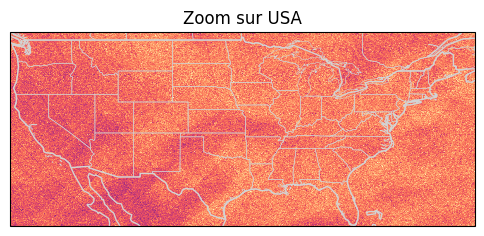

In [10]:
plot_zoom_region(output_data[var], "USA", 25, 50, -125, -65)

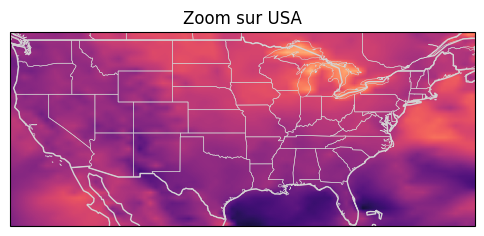

In [11]:
plot_zoom_region(target_data[var], "USA", 25, 50, -125, -65)

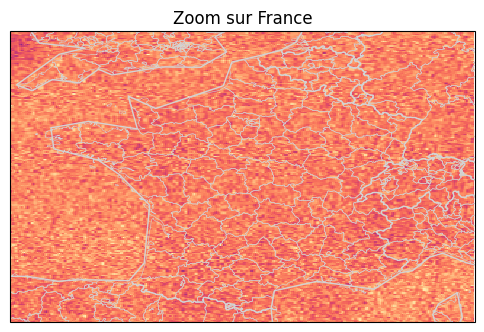

In [12]:
plot_zoom_region(output_data[var], "France", 42, 52, -6, 10)

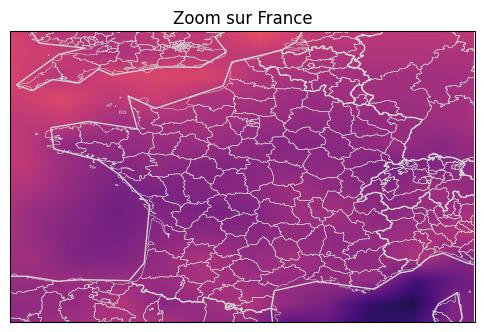

In [13]:
plot_zoom_region(target_data[var], "France", 42, 52, -6, 10)

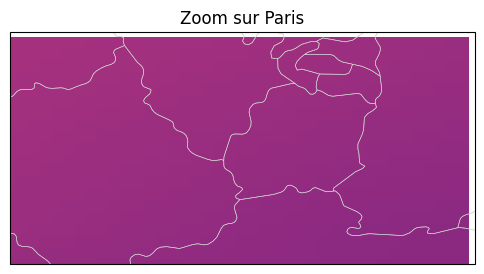

In [14]:
plot_zoom_region(target_data[var], "Paris", 48, 49, 1, 3)